In [4]:
using PyPlot
using PyCall
@pyimport scipy.interpolate as si

In [5]:
function MakeHexagon(Nx::Int)
      Npara=Nx^2;
      N=Npara*3;

      unit=transpose([cos(pi/6),sin(pi/6)])
      a=transpose([2*cos(π/6),0]);
      b=[cos(π/6),1+sin(π/6)];
      bM=transpose(repeat(b,outer=[1,Nx]))
      rotmat=[[cos(2*π/3) -sin(2*π/3)]
            [sin(2*π/3) cos(2*π/3)]]


      Xb=Array{Float64}(N,2);
      Xw=Array{Float64}(N,2);

      ## Creating the positions in the first parallelogram
      for i in 1:Nx
        Xb[i,:]=(i-1)*a;
        Xw[i,:]=unit+(i-1)*a;
      end

      for j in 2:Nx
        Xb[(Nx*(j-1)+1):(Nx*(j-1)+Nx),:]=Xb[1:Nx,:]+(j-1)*bM;
        Xw[(Nx*(j-1)+1):(Nx*(j-1)+Nx),:]=Xw[1:Nx,:]+(j-1)*bM;
      end

      subt=Xb[Npara,2]+1
      Xb[1:Npara,1]=Xb[1:Npara,1]-(Nx-1)*b[1];
      Xw[1:Npara,1]=Xw[1:Npara,1]-(Nx-1)*b[1];
      Xb[1:Npara,2]=Xb[1:Npara,2]-subt;
      Xw[1:Npara,2]=Xw[1:Npara,2]-subt;

      Xb[Npara+(1:Npara),1]=rotmat[1,1]*Xb[1:Npara,1]+rotmat[1,2]*Xb[1:Npara,2];
      Xw[Npara+(1:Npara),1]=rotmat[1,1]*Xw[1:Npara,1]+rotmat[1,2]*Xw[1:Npara,2];
      Xb[Npara+(1:Npara),2]=rotmat[2,1]*Xb[1:Npara,1]+rotmat[2,2]*Xb[1:Npara,2];
      Xw[Npara+(1:Npara),2]=rotmat[2,1]*Xw[1:Npara,1]+rotmat[2,2]*Xw[1:Npara,2];

      Xb[2*Npara+(1:Npara),1]=rotmat[1,1]*Xb[Npara+(1:Npara),1]+rotmat[1,2]*Xb[Npara+(1:Npara),2];
      Xw[2*Npara+(1:Npara),1]=rotmat[1,1]*Xw[Npara+(1:Npara),1]+rotmat[1,2]*Xw[Npara+(1:Npara),2];
      Xb[2*Npara+(1:Npara),2]=rotmat[2,1]*Xb[Npara+(1:Npara),1]+rotmat[2,2]*Xb[Npara+(1:Npara),2];
      Xw[2*Npara+(1:Npara),2]=rotmat[2,1]*Xw[Npara+(1:Npara),1]+rotmat[2,2]*Xw[Npara+(1:Npara),2];

      vb=sortperm(Xb[:,1]+Npara*Xb[:,2])
      vw=sortperm(Xw[:,1]+Npara*Xw[:,2])
      Xb=Xb[vb,:];
      Xw=Xw[vw,:];


  return Xb, Xw
end

MakeHexagon (generic function with 1 method)

In [6]:
function MakeBonds(Nx::Int,Xb::Array{Float64,2},Xw::Array{Float64,2})
  Npara=Nx^2;
  N=Npara*3;

  nrowb=[collect(Nx:(2*Nx));collect((2*Nx-1):-1:(Nx+1))]
  nroww=flipdim(nrowb,1)

  i0b=ones(nrowb)
  i0w=ones(nroww)
  for i in 2:length(nrowb)
      i0b[i]=i0b[i-1]+nrowb[i-1]
      i0w[i]=i0w[i-1]+nroww[i-1]
  end
  push!(i0b,N+1);
  push!(i0w,N+1);

  offsetb=zeros(N+1)
  offsetw=zeros(N+1)
  for i in 1:Nx
      offsetb[i0b[i]:i0b[i+1]]=i-1
      offsetb[i0b[i+Nx]:i0b[i+1+Nx]]=Nx-i
      offsetw[i0w[i]:i0w[i+1]]=i-1
      offsetw[i0w[i+Nx]:i0w[i+1+Nx]]=Nx-i
  end

  Bondsw=Array{Int64}(N,3);
  Bondsb=Array{Int64}(N,3);
  for i in 1:N
      Bondsb[i,2]=i+offsetb[i];
      Bondsw[i,2]=i-offsetw[i];
      Bondsb[i,1]=i+1+offsetb[i];
      Bondsw[i,1]=i-1-offsetw[i];
      Bondsb[i,3]=i-Nx;
      Bondsw[i,3]=i+Nx;
  end

  boundaryb=ones(Int64,N,3);
  boundaryw=ones(Int64,N,3);
  i=1
  while isapprox(Xb[1,2],Xb[i,2])
      Bondsb[i,3]=N-Nx+i
      boundaryb[i,3]=0
      Bondsw[N-Nx+i,3]=i
      boundaryw[N-Nx+i,3]=0
      #println(N-Nx+i,' ',i)
      i+=1
  end

  Bondsw[i0w[1:Nx],1]=i0b[Nx+1+(1:Nx)]-1;
  boundaryw[i0w[1:Nx],1]=0
  Bondsb[i0b[Nx+1+(1:Nx)]-1,1]=i0w[1:Nx];
  boundaryb[i0b[Nx+1+(1:Nx)]-1,1]=0

  Bondsw[i0w[1+(1:Nx)]-1,2]=i0b[Nx+(1:Nx)];
  boundaryw[i0w[1+(1:Nx)]-1,2]=0
  Bondsb[i0b[Nx+(1:Nx)],2]=i0w[1+(1:Nx)]-1;
  boundaryb[i0b[Nx+(1:Nx)],2]=0

  return Bondsb, Bondsw, boundaryb, boundaryw
end

MakeBonds (generic function with 1 method)

In [7]:
function MakeS(N, Bondsw, bw)
      J=Array{Int8}(N,3);
      for i in 1:N
        for j in 1:3
            J[i,j]=1;
        end
      end

      uw=ones(Int8,N,3);
      ub=ones(Int8,N,3);

      S=spzeros(N, N);

      for ii in 1:N
          for jj in 1:3
              S[ii,Bondsw[ii,jj]]=J[ii,jj]*uw[ii,jj]*bw[ii,jj];
          end
      end
      return S;
end


MakeS (generic function with 1 method)

In [48]:
Nx=5
N=3*Nx.^2

75

In [49]:
Xb,Xw=MakeHexagon(Nx);

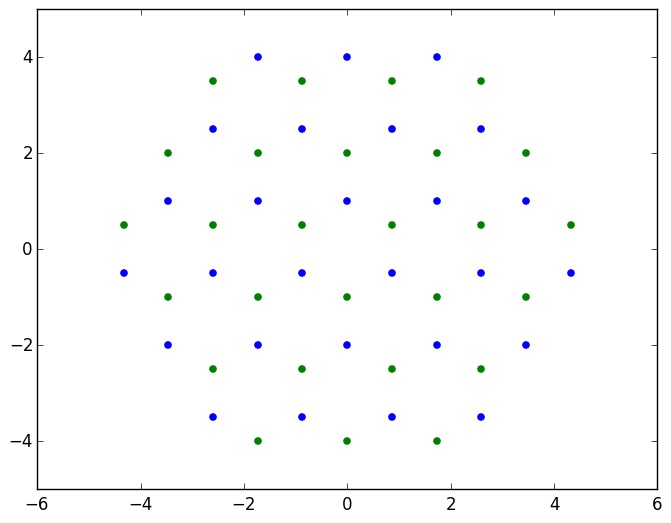

PyObject <matplotlib.collections.PathCollection object at 0x31abcd3d0>

In [11]:
scatter(Xb[:,1],Xb[:,2],color="green")
scatter(Xw[:,1],Xw[:,2],color="blue")

In [50]:
Bondsb,Bondsw,bb,bw=MakeBonds(Nx,Xb,Xw);

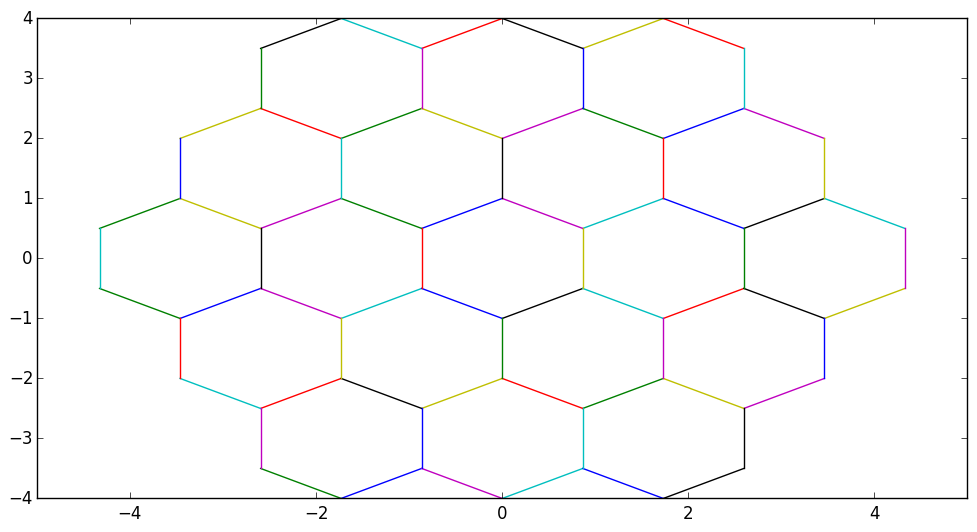

In [14]:
# plot the bonds
if true
    w, h = plt[:figaspect](.5)
    figure(figsize=(w,h))
    for i in 1:3*Nx.^2
        #println(Xb[i,1],' ',Bondsb[i,1])
        xx=[Xb[i,1]*bb[i,1], Xw[Bondsb[i,1],1]*bb[i,1] ]
        yx=[Xb[i,2]*bb[i,1], Xw[Bondsb[i,1],2]*bb[i,1] ]
        plot(xx,yx)
            
        xx=[Xb[i,1]*bb[i,2], Xw[Bondsb[i,2],1]*bb[i,2] ]
        yx=[Xb[i,2]*bb[i,2], Xw[Bondsb[i,2],2]*bb[i,2] ]
        plot(xx,yx)
    
        #println(i,' ',Bonds[i,3])
        xx=[Xb[i,1]*bb[i,3], Xw[Bondsb[i,3],1]*bb[i,3] ]
        yx=[Xb[i,2]*bb[i,3], Xw[Bondsb[i,3],2]*bb[i,3] ]
        plot(xx,yx)

    end
end

In [51]:
S=MakeS(N,Bondsw, bw);

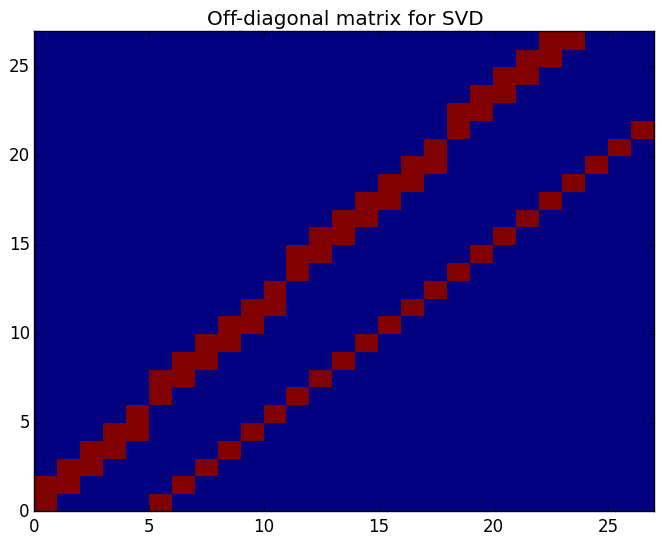

PyObject <matplotlib.text.Text object at 0x31c2f6b50>

In [52]:
pcolor(full(S))
ylim(0,27)
xlim(0,27)
title("Off-diagonal matrix for SVD")

In [53]:
F=svdfact(full(S));

In [54]:
maximum(F[:U]*diagm(F[:S])*F[:Vt]-full(S))

1.9984014443252818e-15

In [55]:
U=F[:U];
V=F[:V];

In [104]:
vu=U[:,end-10]#+U[:,end-4]
vv=V[:,end-10]#+V[:,end-4]
cu=(vu-minimum(vu))./(maximum(vu)-minimum(vu));
cv=(vv-minimum(vv))./(maximum(vv)-minimum(vv));

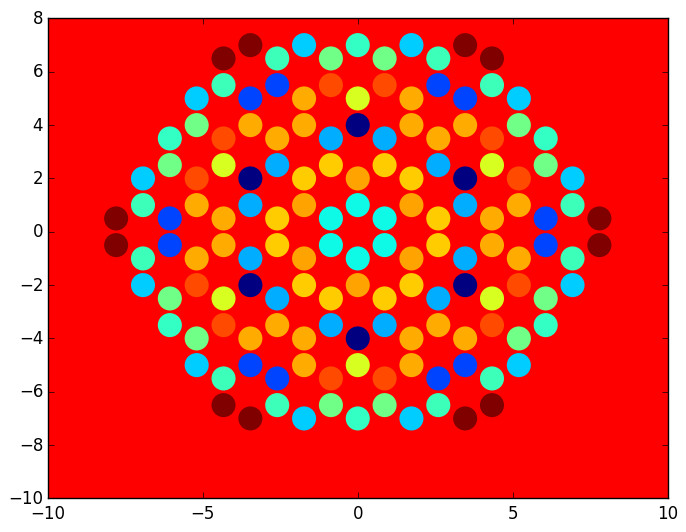

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x3213ee9d0>)

In [113]:
scatter(Xw[:,1],Xw[:,2],c=cu,linewidth=0,s=300)
scatter(Xb[:,1],Xb[:,2],c=cv,linewidth=0,s=300)
ax=axes()
fig=figure(facecolor="red")
ax[:set_axis_bgcolor]("red")

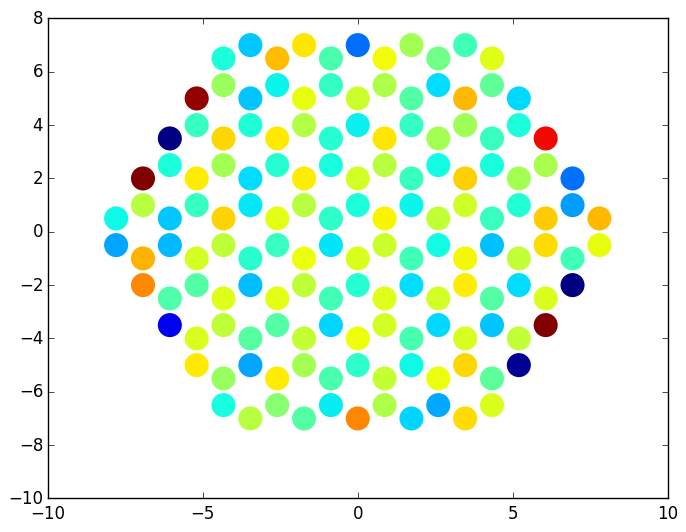

PyObject <matplotlib.collections.PathCollection object at 0x31d1a6f90>

In [62]:
scatter(Xw[:,1],Xw[:,2],c=cu2,linewidth=0,s=300)
scatter(Xb[:,1],Xb[:,2],c=cv2,linewidth=0,s=300)

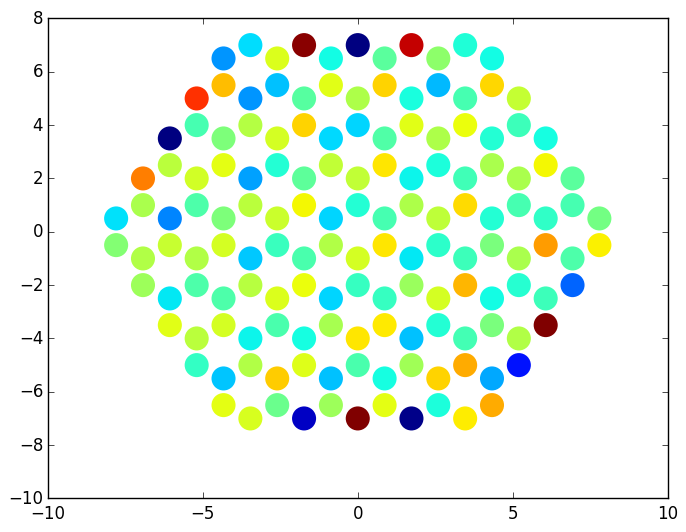

PyObject <matplotlib.collections.PathCollection object at 0x31db3ee50>

In [66]:
scatter(Xw[:,1],Xw[:,2],c=(cu+cu2)/2,linewidth=0,s=300)
scatter(Xb[:,1],Xb[:,2],c=(cv+cv2)/2,linewidth=0,s=300)

In [ ]:
scatter(Xb[:,2],F[:U][:,end])

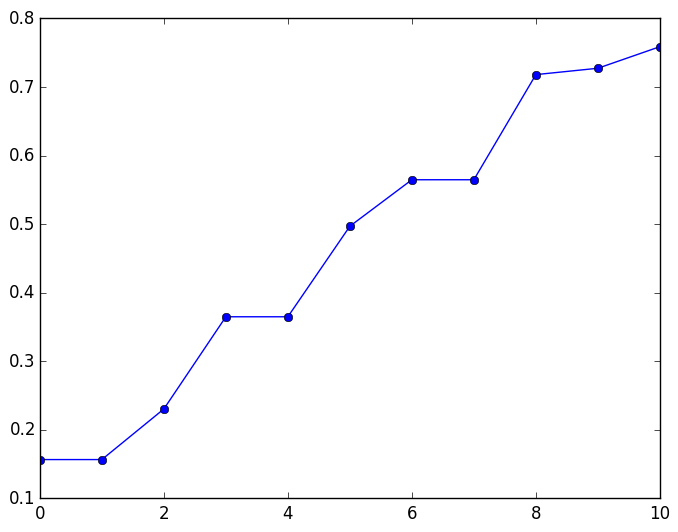

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31ec23c10>

In [87]:
plot(F[:S][end:-1:end-10],marker="o")

In [ ]:
using PyCall
@pyimport scipy.interpolate as si
grid0=si.griddata(cat(1,Xb,Xw),cat(1,U[:,end-1],V[:,end-1]),(xmat,ymat),method="nearest");

In [ ]:
xmin=5;
xmat=repmat(collect(-xmin:.25:xmin),1,8*xmin+1);
ymat=repmat(transpose(collect(-xmin:.25:xmin)),8*xmin+1,1);

In [ ]:
pcolor(xmat,ymat,grid0)
colorbar()